In [4]:
from torchvision.utils import save_image
from AdvFaceGAN import Generator
import torch
import torchvision
from PIL import Image

# 用AdvFaceDefGAN 生成安全人脸看看
defense_generator = Generator(is_target=False).to("cuda")
defense_generator.load_state_dict(torch.load("modle.pth",weights_only=True))
defense_generator=defense_generator.eval()

test_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),])
fake_after = test_transforms(Image.open(f"fake.png").convert('RGB')).unsqueeze(0).cuda()
with  torch.no_grad():
    purge_pert,purge_face = defense_generator.forward(fake_after)
torchvision.utils.save_image(purge_face[0:1], 'purge_face.png', nrow=1)
torchvision.utils.save_image(purge_pert[0:1]*0.5+0.5, 'purge_pert.png', nrow=1)

In [5]:
# 数据预处理类型 防御基线
from io import BytesIO
import numpy as np
from PIL import ImageFilter
import torch.nn.functional as F


class DefenseMethodsPIL:
    # 图像预处理管道
    def __init__(self):
        pass
    
    @staticmethod
    def no_defense(img):
        return img
    
    @staticmethod
    def random_rotate(img, max_angle):
        """随机旋转（保持图像完整尺寸）"""
        angle = np.random.uniform(-max_angle, max_angle)
        return img.rotate(angle, expand=False, fillcolor=(0,0,0))  # 黑色填充
    
    @staticmethod
    def scale_and_pad(img, scale_range):
        """随机缩放+边缘填充"""
        w, h = img.size
        scale = np.random.uniform(1-scale_range,1+scale_range)
        new_size = int(w*scale), int(h*scale)
        
        # 缩放并保持宽高比
        scaled = img.resize(new_size, Image.BILINEAR)
        
        # 创建新画布并居中粘贴
        canvas = Image.new('RGB', (w,h), (0,0,0))
        offset = ((w - new_size[0])//2, (h - new_size[1])//2)
        canvas.paste(scaled, offset)
        return canvas.resize((w,h))  # 二次缩放确保尺寸
    
    @staticmethod
    def gaussian_blur(img, radius):
        """高斯模糊"""
        return img.filter(ImageFilter.GaussianBlur(radius))
    
    @staticmethod
    def jpeg_compression(img, quality):
        """JPEG压缩（模拟保存质量损失）"""
        with BytesIO() as buf:
            img.save(buf, format='JPEG', quality=quality)
            buf.seek(0)
            return Image.open(buf).convert('RGB')
    
    @staticmethod
    def bit_depth_reduction(img, bits):
        """位深缩减（Pillow量化方法）"""
        max_val = 2**bits
        return Image.eval(img, lambda x: (x // (256//max_val)) * (256//max_val))
    
    @staticmethod
    def random_crop(img, crop_ratio):
        """随机裁剪+填充恢复尺寸"""
        w, h = img.size
        new_w, new_h = int(w*(1-crop_ratio)), int(h*(1-crop_ratio))
        left = np.random.randint(0, w - new_w)
        top = np.random.randint(0, h - new_h)
        cropped = img.crop((left, top, left+new_w, top+new_h))
        return cropped.resize((w,h), Image.BILINEAR)
    
    @staticmethod
    def AdvFaceDefGAN(img):
        # 图像预处理管道
        preprocess = transforms.Compose([transforms.ToTensor(),])
        _,purge_face = defense_generator.forward(preprocess(img).unsqueeze(0).cuda())
        # 移除批次维度并转移到CPU
        purge_face = purge_face.squeeze(0).cpu()
        # 转换到[0,1]范围并转为numpy
        tensor = torch.clamp(purge_face, 0, 1)  # 确保数值范围合理
        numpy_image = tensor.permute(1, 2, 0).detach().numpy()  # (H, W, C)
        numpy_image = (numpy_image * 255).astype('uint8')
        return Image.fromarray(numpy_image)


In [6]:
import os
import random

# 加载LFW数据集路径
lfw_root = r"F:\dataset\lfw-aligned-112x112"
identity_folders = [f for f in os.listdir(lfw_root) if os.path.isdir(os.path.join(lfw_root, f))]

# 生成正样本对（同人）
positive_pairs = []
for identity in identity_folders:
    images = os.listdir(os.path.join(lfw_root, identity))
    if len(images) >= 2:
        # 随机选择两张不同图像
        pair = random.sample(images, 2)
        positive_pairs.append((os.path.join(identity, pair[0]), os.path.join(identity, pair[1])))

# 如果正样本对不足6000，允许同一人贡献多对（随机补充）
if len(positive_pairs) < 6000:
    remaining_pairs_needed = 6000 - len(positive_pairs)
    while remaining_pairs_needed > 0:
        # 随机选择一个身份
        identity = random.choice(identity_folders)
        images = os.listdir(os.path.join(lfw_root, identity))
        if len(images) >= 2:
            # 随机选择两张不同图像
            pair = random.sample(images, 2)
            new_pair = (os.path.join(identity, pair[0]), os.path.join(identity, pair[1]))
            # 避免重复
            if new_pair not in positive_pairs:
                positive_pairs.append(new_pair)
                remaining_pairs_needed -= 1

# 生成负样本对（非同人）
negative_pairs = []
while len(negative_pairs) < 6000:
    # 随机选择两个不同的身份
    id1, id2 = random.sample(identity_folders, 2)
    # 从每个身份中随机选择一张图像
    img1 = random.choice(os.listdir(os.path.join(lfw_root, id1)))
    img2 = random.choice(os.listdir(os.path.join(lfw_root, id2)))
    # 拼接路径并添加到负样本对
    negative_pairs.append((os.path.join(id1, img1), os.path.join(id2, img2)))

# 保存正负样本对（可选）
with open("pairs.txt", "w") as f:
    # 写入正样本对
    for pair in positive_pairs:
        f.write(f"{pair[0]}\t{pair[1]}\t1\n")
    # 写入负样本对
    for pair in negative_pairs:
        f.write(f"{pair[0]}\t{pair[1]}\t0\n")

print(f"生成正样本对数量: {len(positive_pairs)}")
print(f"生成负样本对数量: {len(negative_pairs)}")

生成正样本对数量: 6000
生成负样本对数量: 6000


In [11]:
import os
# 加载LFW数据集路径
lfw_root = r"F:\dataset\lfw-aligned-112x112"
identity_folders = [f for f in os.listdir(lfw_root) if os.path.isdir(os.path.join(lfw_root, f))]
# 读取正负样本对（可选）
positive_pairs = []
negative_pairs = []

with open("pairs.txt", "r") as f:
    for line in f:
        # 分割每一行的数据，假设格式是: "item1\titem2\tlabel"
        item1, item2, label = line.strip().split("\t")
        if label == '1':
            positive_pairs.append((item1, item2))
        else:
            negative_pairs.append((item1, item2))


In [12]:
from torch.cuda.amp import autocast
import numpy as np
from fr_models.get_model import getmodel
from fr_models.config import threshold_lfw
from torchvision import transforms
from fr_models.get_model import getmodel
from fr_models.config import threshold_lfw
from torchvision.transforms import ToTensor, Normalize
import torch
from tqdm import tqdm
import os
from PIL import Image
from AdvFaceGAN import Generator

# 图像预处理管道
preprocess = transforms.Compose([
    transforms.ToTensor(),
])

def get_features_batch(func, image_paths, batch_size=100):
    """按批次提取特征并直接计算相似度，避免存储所有特征"""
    positive_sims = []
    negative_sims = []
    
    for i in tqdm(range(0, 12000, batch_size)):
        batch_paths = image_paths[i:i + batch_size]
        batch_images = [func(Image.open(path).convert('RGB')) for path in batch_paths]
        batch_tensors = torch.stack([preprocess(img) for img in batch_images]).cuda() * 255
        batch_images_before = [Image.open(path).convert('RGB') for path in batch_paths]
        batch_tensors_before = torch.stack([preprocess(img) for img in batch_images_before]).cuda() * 255
        with torch.no_grad():  # 减少显存占用
            batch_features = model(batch_tensors)
            batch_features_before = model(batch_tensors_before)
        # 直接计算相似度
        for j in range(0, len(batch_features), 2):
            feat1 = batch_features[j]
            feat2 = batch_features_before[j + 1]
            cos_sim = torch.cosine_similarity(feat1.unsqueeze(0), feat2.unsqueeze(0)).item()
            positive_sims.append(cos_sim)
            
    for i in tqdm(range(12000, 24000, batch_size)):
        batch_paths = image_paths[i:i + batch_size]
        batch_images = [func(Image.open(path).convert('RGB')) for path in batch_paths]
        batch_tensors = torch.stack([preprocess(img) for img in batch_images]).cuda() * 255
        
        batch_images_before = [Image.open(path).convert('RGB') for path in batch_paths]
        batch_tensors_before = torch.stack([preprocess(img) for img in batch_images_before]).cuda() * 255
        with torch.no_grad():  # 减少显存占用
            batch_features = model(batch_tensors)
            batch_features_before = model(batch_tensors_before)
        # 直接计算相似度
        for j in range(0, len(batch_features), 2):
            feat1 = batch_features[j]
            feat2 = batch_features_before[j + 1]
            cos_sim = torch.cosine_similarity(feat1.unsqueeze(0), feat2.unsqueeze(0)).item()
            negative_sims.append(cos_sim)
            
    return positive_sims, negative_sims

def evaluate_defense_impact(defense_func, dataset_path, batch_size=100):
    """评估防御方法对对抗样本和正常样本的影响（批量处理版本）"""
    # 初始化统计量
    asr1_cnt,asr2_cnt=0,0
    total_adv, asr1d_cnt, asr2d_cnt = 0, 0, 0
    sum_fts, sum_sts = 0.0, 0.0
    sum_fss, sum_sss = 0.0, 0.0

    # 收集所有样本路径
    sample_dirs = [os.path.join(dataset_path, d) for d in os.listdir(dataset_path)]
    
    # 图像预处理管道
    preprocess = transforms.Compose([transforms.ToTensor()])

    for batch_idx in tqdm(range(0, len(sample_dirs), batch_size)):
        batch_dirs = sample_dirs[batch_idx:batch_idx + batch_size]
        
        # 初始化批量数据容器
        fakes, sources, targets = [], [], []
        safes = []
        
        # 加载并处理当前batch数据
        for sample_dir in batch_dirs:
            # 加载图像
            fake = Image.open(f"{sample_dir}/adv.png").convert('RGB')
            source = Image.open(f"{sample_dir}/source.png").convert('RGB')
            target = Image.open(f"{sample_dir}/target.png").convert('RGB')
            
            # 应用防御处理
            safe = defense_func(fake)
            
            # 转换为Tensor并添加到列表
            fakes.append(preprocess(fake).unsqueeze(0))
            sources.append(preprocess(source).unsqueeze(0))
            targets.append(preprocess(target).unsqueeze(0))
            safes.append(preprocess(safe).unsqueeze(0))
        
        # 堆叠成批量Tensor并传输到GPU
        def to_cuda(x):
            return torch.cat(x, dim=0).cuda()
        
        fakes_batch = to_cuda(fakes)
        sources_batch = to_cuda(sources)
        targets_batch = to_cuda(targets)
        safes_batch = to_cuda(safes)

        # 定义特征提取函数
        def get_features(tensor):
            return model(F.interpolate(tensor*255, size=img_shape, mode='bilinear'))

        # 批量提取特征
        with torch.no_grad():
            feat_fakes = get_features(fakes_batch)
            feat_sources = get_features(sources_batch)
            feat_targets = get_features(targets_batch)
            feat_safes = get_features(safes_batch)

        # 批量计算相似度
        sim_fss = torch.cosine_similarity(feat_fakes, feat_sources, dim=1)
        sim_fts = torch.cosine_similarity(feat_fakes, feat_targets, dim=1)
        
        sim_sss = torch.cosine_similarity(feat_safes, feat_sources, dim=1)
        sim_sts = torch.cosine_similarity(feat_safes, feat_targets, dim=1)
        

        # 更新统计量
        batch_size_actual = len(batch_dirs)
        total_adv += batch_size_actual
        asr1_cnt += (sim_fts > th).sum().item()
        asr2_cnt += ((sim_fss > th)&(sim_fts > th)).sum().item()
        asr1d_cnt += (sim_sts > th).sum().item()
        asr2d_cnt += ((sim_sss > th)&(sim_sts > th)).sum().item()

        sum_fss += sim_fss.sum().item()
        sum_fts += sim_fts.sum().item()
        sum_sss += sim_sss.sum().item()
        sum_sts += sim_sts.sum().item()

    # 计算最终指标
    asr1 = asr1_cnt / total_adv if total_adv else 0
    asr2 = asr2_cnt / total_adv if total_adv else 0
    asr1d = asr1d_cnt / total_adv if total_adv else 0
    asr2d = asr2d_cnt / total_adv if total_adv else 0

    avg_s_fss = (sum_sss-sum_fss) / total_adv if total_adv else 0
    avg_s_fts = (sum_sts-sum_fts) / total_adv if total_adv else 0
    
    # ['ASR1-ASR1d', 'ASR2-ASR2d','S-FSS', 'S-FTS']
    return {
        'ASR1':round(asr1*100, 4),
        'ASR2':round(asr2*100, 4),
        'ASR1d':round(asr1d*100, 4),
        'ASR2d':round(asr2d*100, 4),
        'ASR1-ASR1d': round((asr1-asr1d)*100, 4),
        'ASR2-ASR2d': round((asr2-asr2d)*100, 4),
        'S-FSS': round(avg_s_fss*100, 4),
        'S-FTS': round(avg_s_fts*100, 4),
        'FSS': round(sum_fss/ total_adv *100, 4),
        'FTS': round(sum_fts/ total_adv *100, 4),
    }


In [11]:
defense_configs = {
    'Rotation': {'func': DefenseMethodsPIL.random_rotate, 'params': {'max_angle': [10,15,20,25,30,35]}},  # 旋转角度范围
    'Scale+Pad': {'func': DefenseMethodsPIL.scale_and_pad, 'params': {'scale_range': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]}},  # 缩放范围
    'Gaussian Blur': {'func': DefenseMethodsPIL.gaussian_blur, 'params': {'radius': [1, 2, 3, 4, 5, 6]}},  # 高斯模糊半径
    'JPEG press': {'func': DefenseMethodsPIL.jpeg_compression, 'params': {'quality': [40,50,60,70,80,90]}},  # JPEG压缩质量
    'bit Quant': {'func': DefenseMethodsPIL.bit_depth_reduction, 'params': {'bits': [2,3,4,5,6,7]}},  # 位深缩减
    'Crop': {'func': DefenseMethodsPIL.random_crop, 'params': {'crop_ratio': [0.3,0.25,0.2,0.15,0.1,0.05]}}  # 裁剪比例
}
import matplotlib.pyplot as plt

# 获取所有图像路径
positive_paths = [os.path.join(lfw_root, path) for pair in positive_pairs for path in pair]
negative_paths = [os.path.join(lfw_root, path) for pair in negative_pairs for path in pair]
# 调参并计算 TAR 和 FAR
results = {}
model_names = ["IR50-Softmax",'FaceNet-VGGFace2','ArcFace']

for name, config in defense_configs.items():
    results[name]={}
    for model_name in model_names:
        model,img_shape = getmodel(model_name)  # 初始化模型  改成IR50-PGDSoftmax IR50-TradesSoftmax就能测试对抗训练模型
        th = threshold_lfw[model_name]['cos']
        func = config['func']
        params = config['params']
        param_name = list(params.keys())[0]
        param_values = params[param_name]

        tars = []
        fars = []
        ASRR1s = []
        ASRR2s = []
        for value in param_values:
            print(name,param_name,value)
            if isinstance(value, np.ndarray):  # 如果 value 是数组，取第一个值
                value = value[0]
            
            # 定义当前参数下的防御函数
            current_func = lambda img: func(img, **{param_name: value})
        
            # 按批次提取特征
            positive_sims, negative_sims = get_features_batch(current_func, positive_paths + negative_paths, batch_size=300)
                
            # 计算 TAR 和 FAR
            tar = np.sum(np.array(positive_sims) >= th) / len(positive_sims)
            far = np.sum(np.array(negative_sims) >= th) / len(negative_sims)
            # 模型识别性能
            tars.append(tar)
            fars.append(far)
            # 防御能力 
            # data/SiblingAttack_ArcFace_lfw_eps0.15_tpert10.7
            # data/SiblingAttack_ResNet50_lfw_eps0.15_tpert10.7
            # data/AdvFaceGAN_target 5 8白盒 奇怪ssim 92ssim 双身份损失0.15 2490_lfw_eps5_tpert4.6
            defense_metric = evaluate_defense_impact(current_func,f"data/AdvFaceGAN_target 5 8白盒 奇怪ssim 92ssim 双身份损失0.15 2490_lfw_eps5_tpert4.6")
            ASRR1s.append(defense_metric['ASR1-ASR1d'])
            ASRR2s.append(defense_metric['ASR2-ASR2d'])
            # print(defense_metric)
        # 存储结果
        results[name][model_name] = {
            'param_name': param_name,
            'param_values': param_values,
            'tars': tars,
            'fars': fars,
            'ASR1-ASR1d':ASRR1s,
            'ASR2-ASR2d':ASRR2s,
        }

Load existing checkpoint
Rotation max_angle 10


100%|██████████| 10/10 [00:13<00:00,  1.38s/it]


Rotation max_angle 15


100%|██████████| 10/10 [00:12<00:00,  1.27s/it]


Rotation max_angle 20


100%|██████████| 10/10 [00:12<00:00,  1.29s/it]


Rotation max_angle 25


100%|██████████| 10/10 [00:12<00:00,  1.25s/it]


Rotation max_angle 30


100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


Rotation max_angle 35


100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


Load existing checkpoint
Rotation max_angle 10


100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


Rotation max_angle 15


100%|██████████| 10/10 [00:08<00:00,  1.17it/s]


Rotation max_angle 20


100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


Rotation max_angle 25


100%|██████████| 10/10 [00:08<00:00,  1.23it/s]


Rotation max_angle 30


100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


Rotation max_angle 35


100%|██████████| 10/10 [00:08<00:00,  1.17it/s]


Load existing checkpoint
Rotation max_angle 10


100%|██████████| 10/10 [00:13<00:00,  1.32s/it]


Rotation max_angle 15


100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


Rotation max_angle 20


100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


Rotation max_angle 25


100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


Rotation max_angle 30


100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


Rotation max_angle 35


100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


Load existing checkpoint
Scale+Pad scale_range 0.1


100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


Scale+Pad scale_range 0.2


100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


Scale+Pad scale_range 0.3


100%|██████████| 10/10 [00:12<00:00,  1.20s/it]


Scale+Pad scale_range 0.4


100%|██████████| 10/10 [00:11<00:00,  1.20s/it]


Scale+Pad scale_range 0.5


100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


Scale+Pad scale_range 0.6


100%|██████████| 10/10 [00:13<00:00,  1.33s/it]


Load existing checkpoint
Scale+Pad scale_range 0.1


100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


Scale+Pad scale_range 0.2


100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


Scale+Pad scale_range 0.3


100%|██████████| 10/10 [00:08<00:00,  1.11it/s]


Scale+Pad scale_range 0.4


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


Scale+Pad scale_range 0.5


100%|██████████| 10/10 [00:09<00:00,  1.11it/s]


Scale+Pad scale_range 0.6


100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


Load existing checkpoint
Scale+Pad scale_range 0.1


100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


Scale+Pad scale_range 0.2


100%|██████████| 10/10 [00:12<00:00,  1.20s/it]


Scale+Pad scale_range 0.3


100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


Scale+Pad scale_range 0.4


100%|██████████| 10/10 [00:12<00:00,  1.29s/it]


Scale+Pad scale_range 0.5


100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


Scale+Pad scale_range 0.6


100%|██████████| 10/10 [00:11<00:00,  1.10s/it]


Load existing checkpoint
Gaussian Blur radius 1


100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


Gaussian Blur radius 2


100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


Gaussian Blur radius 3


100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


Gaussian Blur radius 4


100%|██████████| 10/10 [00:12<00:00,  1.20s/it]


Gaussian Blur radius 5


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


Gaussian Blur radius 6


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


Load existing checkpoint
Gaussian Blur radius 1


100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


Gaussian Blur radius 2


100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


Gaussian Blur radius 3


100%|██████████| 10/10 [00:08<00:00,  1.17it/s]


Gaussian Blur radius 4


100%|██████████| 10/10 [00:08<00:00,  1.17it/s]


Gaussian Blur radius 5


100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


Gaussian Blur radius 6


100%|██████████| 10/10 [00:08<00:00,  1.17it/s]


Load existing checkpoint
Gaussian Blur radius 1


100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


Gaussian Blur radius 2


100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


Gaussian Blur radius 3


100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


Gaussian Blur radius 4


100%|██████████| 10/10 [00:13<00:00,  1.31s/it]


Gaussian Blur radius 5


100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


Gaussian Blur radius 6


100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


Load existing checkpoint
JPEG press quality 40


100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


JPEG press quality 50


100%|██████████| 10/10 [00:12<00:00,  1.20s/it]


JPEG press quality 60


100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


JPEG press quality 70


100%|██████████| 10/10 [00:11<00:00,  1.20s/it]


JPEG press quality 80


100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


JPEG press quality 90


100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


Load existing checkpoint
JPEG press quality 40


100%|██████████| 10/10 [00:08<00:00,  1.22it/s]


JPEG press quality 50


100%|██████████| 10/10 [00:08<00:00,  1.22it/s]


JPEG press quality 60


100%|██████████| 10/10 [00:08<00:00,  1.22it/s]


JPEG press quality 70


100%|██████████| 10/10 [00:08<00:00,  1.23it/s]


JPEG press quality 80


100%|██████████| 10/10 [00:08<00:00,  1.17it/s]


JPEG press quality 90


100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


Load existing checkpoint
JPEG press quality 40


100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


JPEG press quality 50


100%|██████████| 10/10 [00:10<00:00,  1.10s/it]


JPEG press quality 60


100%|██████████| 10/10 [00:11<00:00,  1.10s/it]


JPEG press quality 70


100%|██████████| 10/10 [00:10<00:00,  1.10s/it]


JPEG press quality 80


100%|██████████| 10/10 [00:11<00:00,  1.11s/it]


JPEG press quality 90


100%|██████████| 10/10 [00:11<00:00,  1.11s/it]


Load existing checkpoint
bit Quant bits 2


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


bit Quant bits 3


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


bit Quant bits 4


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


bit Quant bits 5


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


bit Quant bits 6


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


bit Quant bits 7


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


Load existing checkpoint
bit Quant bits 2


100%|██████████| 10/10 [00:06<00:00,  1.43it/s]


bit Quant bits 3


100%|██████████| 10/10 [00:06<00:00,  1.44it/s]


bit Quant bits 4


100%|██████████| 10/10 [00:06<00:00,  1.45it/s]


bit Quant bits 5


100%|██████████| 10/10 [00:07<00:00,  1.41it/s]


bit Quant bits 6


100%|██████████| 10/10 [00:06<00:00,  1.46it/s]


bit Quant bits 7


100%|██████████| 10/10 [00:06<00:00,  1.45it/s]


Load existing checkpoint
bit Quant bits 2


100%|██████████| 10/10 [00:11<00:00,  1.11s/it]


bit Quant bits 3


100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


bit Quant bits 4


100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


bit Quant bits 5


100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


bit Quant bits 6


100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


bit Quant bits 7


100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


Load existing checkpoint
Crop crop_ratio 0.3


100%|██████████| 10/10 [00:10<00:00,  1.10s/it]


Crop crop_ratio 0.25


100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


Crop crop_ratio 0.2


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


Crop crop_ratio 0.15


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


Crop crop_ratio 0.1


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


Crop crop_ratio 0.05


100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


Load existing checkpoint
Crop crop_ratio 0.3


100%|██████████| 10/10 [00:07<00:00,  1.36it/s]


Crop crop_ratio 0.25


100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


Crop crop_ratio 0.2


100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


Crop crop_ratio 0.15


100%|██████████| 10/10 [00:07<00:00,  1.32it/s]


Crop crop_ratio 0.1


100%|██████████| 10/10 [00:07<00:00,  1.29it/s]


Crop crop_ratio 0.05


100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


Load existing checkpoint
Crop crop_ratio 0.3


100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


Crop crop_ratio 0.25


100%|██████████| 10/10 [00:11<00:00,  1.11s/it]


Crop crop_ratio 0.2


100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


Crop crop_ratio 0.15


100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


Crop crop_ratio 0.1


100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


Crop crop_ratio 0.05


100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


In [8]:
import json
# 文件化调优结果
# with open("基于AdvFaceGAN的参数调优.json", "w", encoding="utf-8") as f:
#     json.dump(results, f, ensure_ascii=False, indent=4)

# 加载调优结果
with open("基于AdvFaceGAN的参数调优.json", "r", encoding="utf-8") as f:
    results = json.load(f)


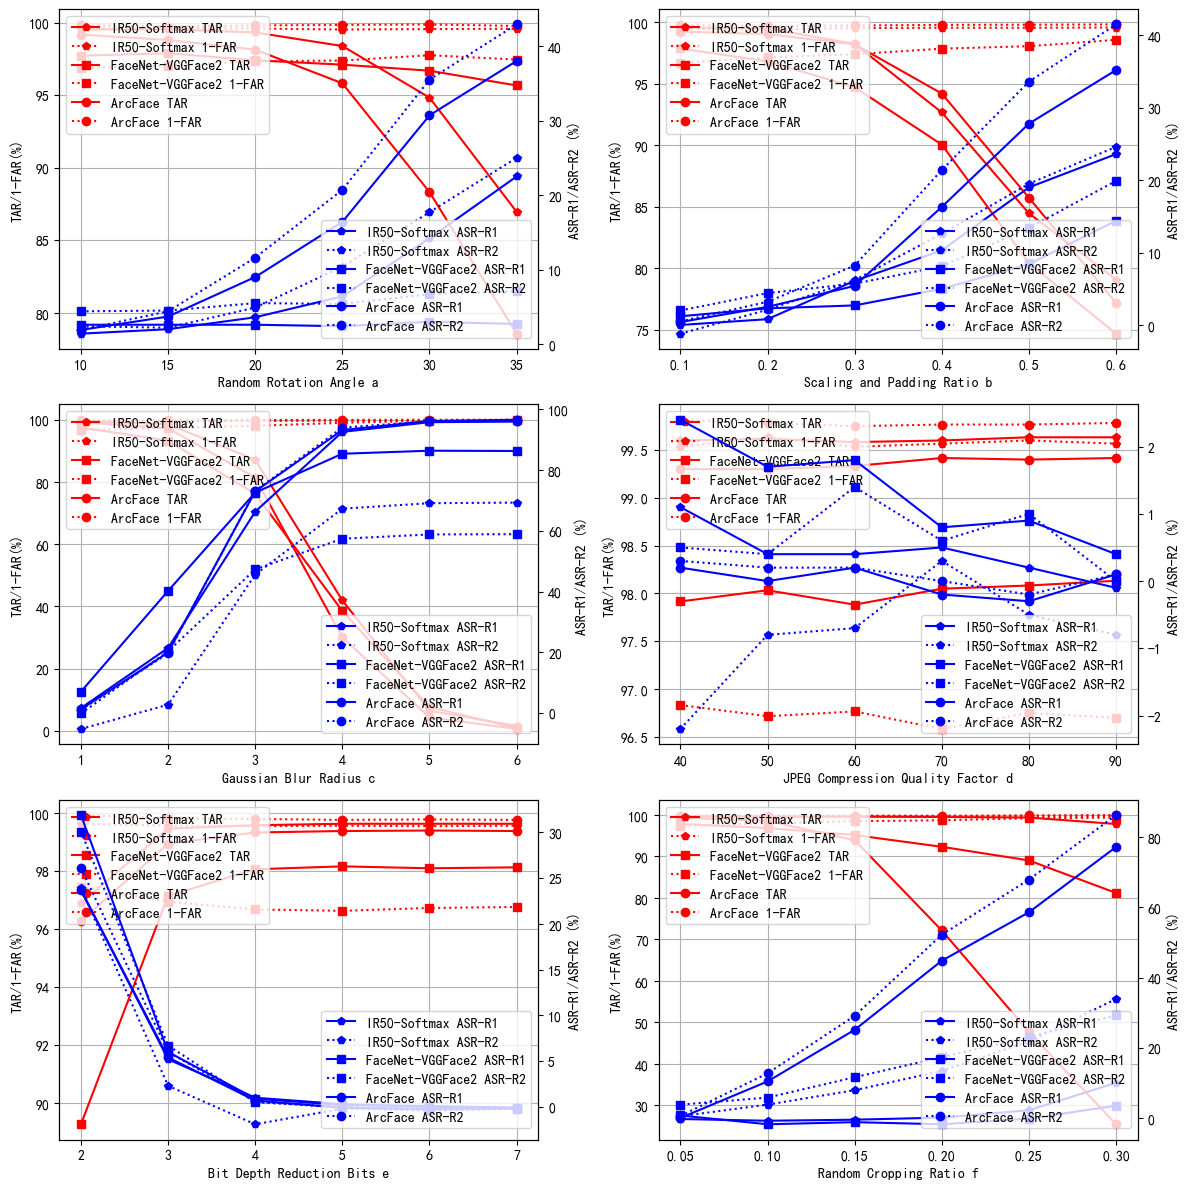

In [9]:
import matplotlib.pyplot as plt
import json

# 设置中文字体和负号显示问题
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体为黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 标记区分不同目标模型
markers = {
    "IR50-Softmax": "p",
    "FaceNet-VGGFace2": "s",
    "ArcFace": "o"
}

defenses = ["Rotation", "Scale+Pad", "Gaussian Blur", "JPEG press", "bit Quant", "Crop"]
chins = ["Random Rotation Angle a", "Scaling and Padding Ratio b", "Gaussian Blur Radius c", "JPEG Compression Quality Factor d", "Bit Depth Reduction Bits e", "Random Cropping Ratio f"]

# 创建一个包含6个子图的图形
fig, axes = plt.subplots(3, 2, figsize=(12, 12))  # 2行3列

# 遍历每个防御方法
for i, (defense, chin) in enumerate(zip(defenses, chins)):
    row = i // 2  # 计算行数
    col = i % 2   # 计算列数
    ax1 = axes[row, col]  # 获取对应的子图位置

    # 创建第二个Y轴
    ax2 = ax1.twinx()

    # 遍历每个模型
    for model, values in results[defense].items():
        x = values["param_values"]
        # TAR/FAR 在左侧 Y 轴
        ax1.plot(x, [i * 100 for i in values["tars"]], linestyle='-', marker=markers[model], color='r', label=f"{model} TAR")
        ax1.plot(x, [(1-i) * 100 for i in values["fars"]], linestyle=':', marker=markers[model], color='r', label=f"{model} 1-FAR")
        # ASR1/ASR2 在右侧 Y 轴
        ax2.plot(x, values["ASR1-ASR1d"], linestyle='-', marker=markers[model], color='b', label=f"{model} ASR-R1")
        ax2.plot(x, values["ASR2-ASR2d"], linestyle=':', marker=markers[model], color='b', label=f"{model} ASR-R2")

    # 设置标签和标题
    ax1.set_xlabel(chin)
    ax1.set_ylabel("TAR/1-FAR(%)", color="black")
    ax2.set_ylabel("ASR-R1/ASR-R2 (%)", color="black")

    # 添加图例
    ax1.legend(loc="upper left", bbox_to_anchor=(0, 1), framealpha=0.8)
    ax2.legend(loc="upper right", bbox_to_anchor=(1, 0.4), framealpha=0.8)

    # 添加网格
    ax1.grid(True)

# 调整布局避免重叠
plt.tight_layout()

# 保存和展示
plt.savefig("combined_fig.png", bbox_inches="tight")
plt.show()


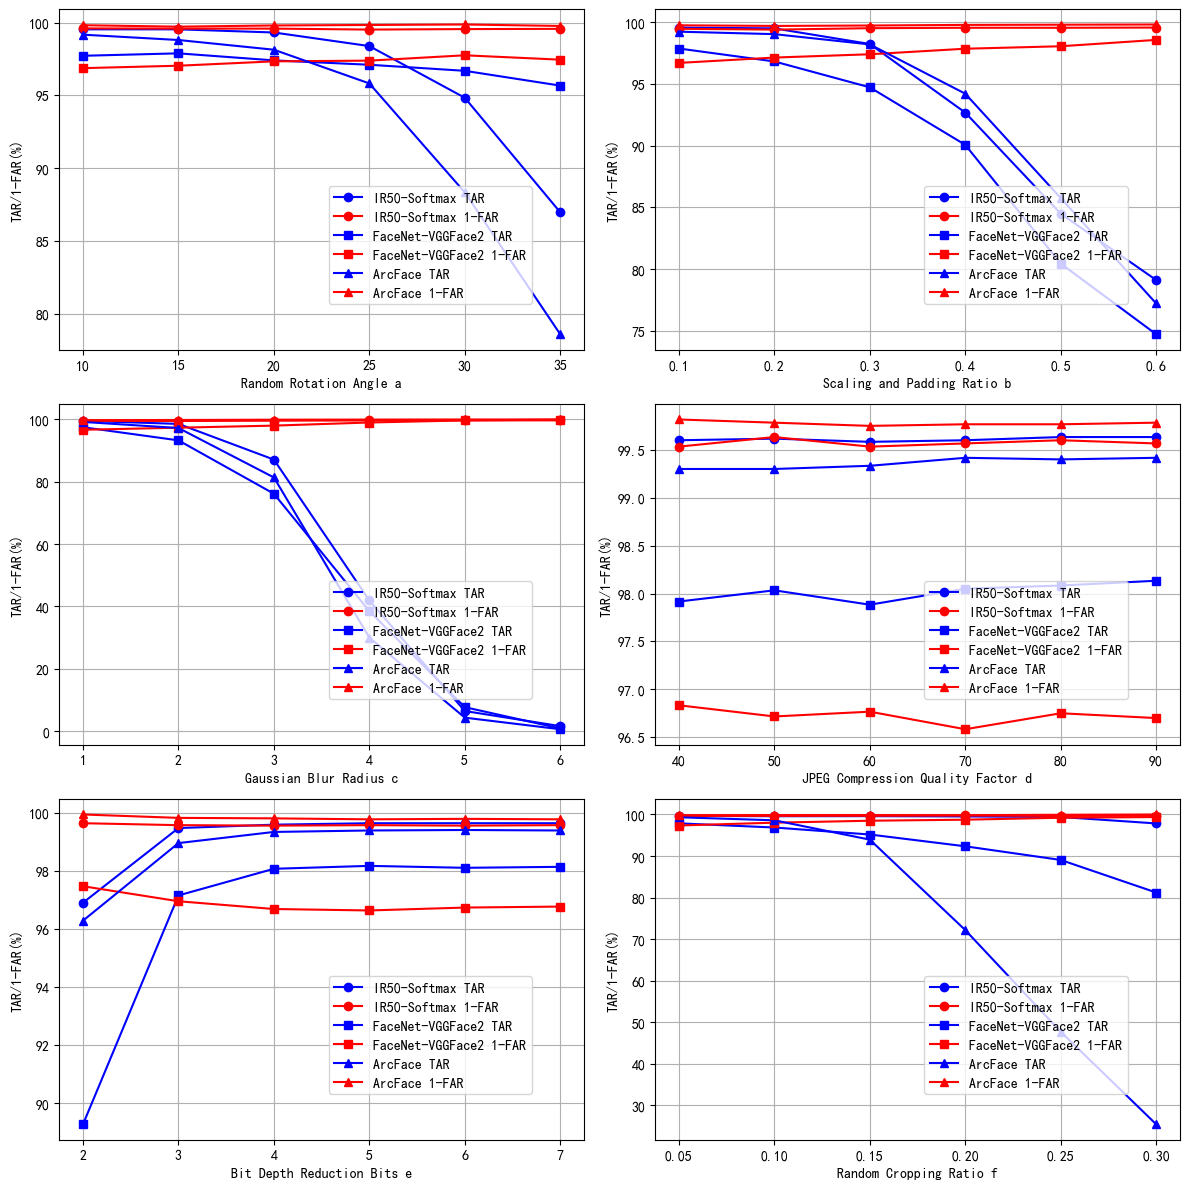

In [10]:
import matplotlib.pyplot as plt
import json

# 设置中文字体和负号显示问题
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体为黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 标记区分不同目标模型
markers = {
    "IR50-Softmax": "o",
    "FaceNet-VGGFace2": "s",
    "ArcFace": "^"
}

defenses = ["Rotation", "Scale+Pad", "Gaussian Blur", "JPEG press", "bit Quant", "Crop"]
chins = ["Random Rotation Angle a", "Scaling and Padding Ratio b", "Gaussian Blur Radius c", "JPEG Compression Quality Factor d", "Bit Depth Reduction Bits e", "Random Cropping Ratio f"]

# 创建一个包含6个子图的图形
fig, axes = plt.subplots(3, 2, figsize=(12, 12))  # 2行3列

# 遍历每个防御方法
for i, (defense, chin) in enumerate(zip(defenses, chins)):
    row = i // 2  # 计算行数
    col = i % 2   # 计算列数
    ax1 = axes[row, col]  # 获取对应的子图位置

    # 遍历每个模型
    for model, values in results[defense].items():
        x = values["param_values"]
        # TAR/FAR 在左侧 Y 轴
        ax1.plot(x, [i * 100 for i in values["tars"]], linestyle='-', marker=markers[model], color='b', label=f"{model} TAR")
        ax1.plot(x, [(1-i) * 100 for i in values["fars"]], linestyle='-', marker=markers[model], color='r', label=f"{model} 1-FAR")

    # 设置标签和标题
    ax1.set_xlabel(chin)
    ax1.set_ylabel("TAR/1-FAR(%)", color="black")

    # 添加图例
    ax1.legend(loc="upper left", bbox_to_anchor=(0.5, 0.5), framealpha=0.8)

    # 添加网格
    ax1.grid(True)

# 调整布局避免重叠
plt.tight_layout()

# 保存和展示
plt.savefig("combined_fig1.png", bbox_inches="tight")
plt.show()


In [18]:
# 模型识别性能实验
defense_configs = {
    # 'no_defense': lambda img: DefenseMethodsPIL.no_defense(img),
    # 'Rotation (25°)': lambda img: DefenseMethodsPIL.random_rotate(img, 25),
    # 'Scale+Pad (0.3)': lambda img: DefenseMethodsPIL.scale_and_pad(img,0.3),
    # 'Gaussian Blur (r=2)': lambda img: DefenseMethodsPIL.gaussian_blur(img, 2),
    # 'JPEG40': lambda img: DefenseMethodsPIL.jpeg_compression(img, 40),
    # '3-bit Quant': lambda img: DefenseMethodsPIL.bit_depth_reduction(img, 3),
    # 'Crop90%': lambda img: DefenseMethodsPIL.random_crop(img, 0.1),
    'AdvFaceDefGAN': lambda img: DefenseMethodsPIL.AdvFaceDefGAN(img),
}

model,img_shape = getmodel("IR50-Softmax")  # 初始化模型  no_defense并改成IR50-PGDSoftmax IR50-TradesSoftmax就能测试对抗训练模型
th = threshold_lfw["IR50-Softmax"]['cos']
for name, func in defense_configs.items():
    # print("使用防御方法{0}：".format(name))
    # 获取所有图像路径
    positive_paths = [os.path.join(lfw_root, path) for pair in positive_pairs for path in pair]
    negative_paths = [os.path.join(lfw_root, path) for pair in negative_pairs for path in pair]
    # 按批次提取特征
    positive_sims, negative_sims = get_features_batch(func, positive_paths + negative_paths, batch_size=100)
    # 计算 TAR 和 FAR
    tar = np.sum(np.array(positive_sims) >= th) / len(positive_sims)
    far = np.sum(np.array(negative_sims) >= th) / len(negative_sims)
    # 输出结果
    print(f"{tar*100}\t{(1-far)*100}")
    print(f"正样本平均相似度: {np.mean(positive_sims)}, 负样本平均相似度: {np.mean(negative_sims)}")

Load existing checkpoint


100%|██████████| 120/120 [02:48<00:00,  1.40s/it]

90.26666666666667	99.6
正样本平均相似度: 0.5425223702047951, 负样本平均相似度: 0.03183402575917232


In [14]:
import os
def visualize_defense_effects(input_image_path, output_dir, defense_class=DefenseMethodsPIL):
    """
    可视化所有防御方法处理效果并保存图像
    :param input_image_path: 输入图像路径
    :param output_dir:  输出目录路径
    :param defense_class: 防御方法类
    """
    # 创建输出目录
    os.makedirs(output_dir, exist_ok=True)
    
    # 加载原始图像
    original_img = Image.open(input_image_path).convert('RGB')
    original_img.save(os.path.join(output_dir, '00_original.png'))

    # 初始化防御方法实例
    defenses = defense_class()

    # 定义各防御方法及参数（可扩展）
    defense_methods = [
        ('random_rotate', {'max_angle': 25}),
        ('scale_and_pad', {'scale_range': 0.3}),
        ('gaussian_blur', {'radius': 2}),
        ('jpeg_compression', {'quality': 40}),
        ('bit_depth_reduction', {'bits': 3}),
        ('random_crop', {'crop_ratio': 0.1}),
    ]

    # 遍历所有防御方法
    for idx, (method_name, params) in enumerate(defense_methods, 1):
        try:
            # 获取防御方法
            method = getattr(defenses, method_name)
            
            # 特殊处理GAN防御
            if method_name == 'AdvFaceDefGAN':
                processed_img = method(original_img)
            else:
                processed_img = method(original_img, **params)
            
            # 生成文件名
            filename = f"{idx:02d}_{method_name}.png"
            
            # 保存处理结果
            save_path = os.path.join(output_dir, filename)
            processed_img.save(save_path)
            print(f"Saved: {save_path}")
            
        except Exception as e:
            print(f"Error processing {method_name}: {str(e)}")

input_img = r"F:\models\AdvFaceDefGAN\data\FGSM_ArcFace_lfw_eps6_tpert4.4\Ahmad_Jbarah_0001+Don_Hewitt_0001\target.png"  # 输入图像路径
output_folder = "defense_visualization/source"  # 输出目录
visualize_defense_effects(input_img, output_folder)
input_img = "data/505data/AdvFaceGAN_target 5 8白盒 奇怪ssim 92ssim 双身份损失0.15 2490_505_eps5_tpert4.5/yy_0001+gj_0001/target.png"  # 输入图像路径
output_folder = "defense_visualization/target"  # 输出目录
visualize_defense_effects(input_img, output_folder)

Saved: defense_visualization/source\01_random_rotate.png
Saved: defense_visualization/source\02_scale_and_pad.png
Saved: defense_visualization/source\03_gaussian_blur.png
Saved: defense_visualization/source\04_jpeg_compression.png
Saved: defense_visualization/source\05_bit_depth_reduction.png
Saved: defense_visualization/source\06_random_crop.png
Saved: defense_visualization/target\01_random_rotate.png
Saved: defense_visualization/target\02_scale_and_pad.png
Saved: defense_visualization/target\03_gaussian_blur.png
Saved: defense_visualization/target\04_jpeg_compression.png
Saved: defense_visualization/target\05_bit_depth_reduction.png
Saved: defense_visualization/target\06_random_crop.png


In [6]:
# 白盒防御
from torchvision import transforms
from fr_models.get_model import getmodel
from fr_models.config import threshold_lfw
from torchvision.transforms import ToTensor, Normalize
import torch
from tqdm import tqdm
import os
from PIL import Image
from AdvFaceGAN import Generator

defense_configs = {
    # 'no_defense': lambda img: DefenseMethodsPIL.no_defense(img),
    'Rotation (25°)': lambda img: DefenseMethodsPIL.random_rotate(img, 25),
    'Scale+Pad (0.3)': lambda img: DefenseMethodsPIL.scale_and_pad(img,0.3),
    'Gaussian Blur (r=2)': lambda img: DefenseMethodsPIL.gaussian_blur(img, 2),
    'JPEG40': lambda img: DefenseMethodsPIL.jpeg_compression(img, 40),
    '3-bit Quant': lambda img: DefenseMethodsPIL.bit_depth_reduction(img, 3),
    'Crop90%': lambda img: DefenseMethodsPIL.random_crop(img, 0.1),
    'AdvFaceDefGAN': lambda img: DefenseMethodsPIL.AdvFaceDefGAN(img),
}

test_whitebox_model_name_list = ['ArcFace'] # ,'FaceNet-VGGFace2','ResNet50'
for model_name in test_whitebox_model_name_list:
    model, img_shape = getmodel(model_name)
    th = threshold_lfw[model_name]['cos']
    adv_samples_dirs = [
        f"data/FGSM_{model_name}_lfw_eps6_tpert4.4",
        f"data/MIM_{model_name}_lfw_eps6_tpert4.4",
        f"data/CW_{model_name}_lfw_eps16_tpert1",
        # f"data/AT3D_{model_name}_eye_nose_lfw_eps5_tpert13.5",
        # f"data/SiblingAttack_{model_name}_lfw_eps0.15_tpert10.7",
        # f"data/AdvFace_lfw_eps8_tpert5.7",
        # f"data/AdvMakeUP_lfw_tpert5.2",
        # f"data/AdvFaceGAN_target 4 8白盒 无stloss 990_lfw_eps4_tpert_4",
        # f"data/AdvFaceGAN_target 5 8白盒 无stloss 990_lfw_eps5_tpert5",
        # f"data/AdvFaceGAN_target 5 8白盒 奇怪ssim 92ssim 双身份损失0.15 2490_lfw_eps5_tpert4.6",
    ]
    for fake_dir in adv_samples_dirs:
        print("开始评估{0}模型下的{1}:".format(model_name,fake_dir))
        results = []
        for name, func in defense_configs.items():
            metrics = evaluate_defense_impact(func, fake_dir,batch_size=50)
            results.append({'Method': name, **metrics})
        # 生成对比表格
        import pandas as pd
        df = pd.DataFrame(results).set_index('Method')
        print(df[['ASR1','ASR2','ASR1-ASR1d', 'ASR2-ASR2d','S-FSS', 'S-FTS']])

Load existing checkpoint
开始评估ArcFace模型下的data/FGSM_ArcFace_lfw_eps6_tpert4.4:


100%|██████████| 20/20 [00:15<00:00,  1.28it/s]


                      ASR1   ASR2  ASR1-ASR1d  ASR2-ASR2d    S-FSS    S-FTS
Method                                                                     
Rotation (25°)       0.998  0.997        23.6        23.9  -2.8383 -16.2647
Scale+Pad (0.3)      0.998  0.997         7.0         7.1   0.6445  -9.4646
Gaussian Blur (r=2)  0.998  0.997        12.8        12.7  10.0477 -15.7579
JPEG40               0.998  0.997         0.4         0.3   3.8883  -3.6115
3-bit Quant          0.998  0.997         0.3         0.3   1.6532  -3.2930
Crop90%              0.998  0.997         8.0         8.0  -0.6140 -11.1716
AdvFaceDefGAN        0.998  0.997        95.5        95.4   7.5057 -53.8706
开始评估ArcFace模型下的data/MIM_ArcFace_lfw_eps6_tpert4.4:


100%|██████████| 20/20 [00:16<00:00,  1.24it/s]


                     ASR1   ASR2  ASR1-ASR1d  ASR2-ASR2d    S-FSS    S-FTS
Method                                                                    
Rotation (25°)        1.0  0.063         3.8       -45.1  15.3276 -26.6849
Scale+Pad (0.3)       1.0  0.063         0.7       -43.3  14.7878 -16.8085
Gaussian Blur (r=2)   1.0  0.063         1.9       -91.3  40.4912 -41.0675
JPEG40                1.0  0.063         0.0       -38.8  13.3489  -6.6200
3-bit Quant           1.0  0.063         0.0       -22.2   8.8292  -6.8357
Crop90%               1.0  0.063         0.0       -35.4  12.4729 -17.8097
AdvFaceDefGAN         1.0  0.063        82.8       -10.9  44.7894 -80.3278
开始评估ArcFace模型下的data/CW_ArcFace_lfw_eps16_tpert1:


100%|██████████| 20/20 [00:16<00:00,  1.24it/s]

                     ASR1  ASR2  ASR1-ASR1d  ASR2-ASR2d   S-FSS    S-FTS
Method                                                                  
Rotation (25°)        1.0   1.0        71.2        71.2 -8.9492 -20.2299
Scale+Pad (0.3)       1.0   1.0        56.0        56.0 -2.1462 -17.5900
Gaussian Blur (r=2)   1.0   1.0        98.7        98.7 -2.5447 -32.7264
JPEG40                1.0   1.0        38.9        38.9  5.2555 -13.8672
3-bit Quant           1.0   1.0        62.8        62.8 -1.0889 -16.6795
Crop90%               1.0   1.0        61.3        61.3 -3.9929 -16.7977
AdvFaceDefGAN         1.0   1.0        99.7        99.7 -7.3688 -66.5575


In [7]:
# 白盒防御
from torchvision import transforms
from fr_models.get_model import getmodel
from fr_models.config import threshold_lfw
from torchvision.transforms import ToTensor, Normalize
import torch
from tqdm import tqdm
import os
from PIL import Image
from AdvFaceGAN import Generator


defense_configs = {
    # 'no_defense': lambda img: DefenseMethodsPIL.no_defense(img),
    'Rotation (25°)': lambda img: DefenseMethodsPIL.random_rotate(img, 25),
    'Scale+Pad (0.3)': lambda img: DefenseMethodsPIL.scale_and_pad(img,0.3),
    'Gaussian Blur (r=2)': lambda img: DefenseMethodsPIL.gaussian_blur(img, 2),
    'JPEG40': lambda img: DefenseMethodsPIL.jpeg_compression(img, 40),
    '3-bit Quant': lambda img: DefenseMethodsPIL.bit_depth_reduction(img, 3),
    'Crop90%': lambda img: DefenseMethodsPIL.random_crop(img, 0.1),
    'AdvFaceDefGAN': lambda img: DefenseMethodsPIL.AdvFaceDefGAN(img),
}

test_whitebox_model_name_list = ['FaceNet-VGGFace2']
for model_name in test_whitebox_model_name_list:
    model, img_shape = getmodel(model_name)
    th = threshold_lfw[model_name]['cos']
    adv_samples_dirs = [
        # f"data/FGSM_{model_name}_lfw_eps6_tpert4.4",
        # f"data/MIM_{model_name}_lfw_eps6_tpert4.4",
        # f"data/CW_{model_name}_lfw_eps16_tpert1",
        f"data/AT3D_{model_name}_eye_nose_lfw_eps5_tpert13.5",
        f"data/SiblingAttack_{model_name}_lfw_eps0.15_tpert10.7",
        f"data/AdvFace_lfw_eps8_tpert5.7",
        # f"data/AdvMakeUP_lfw_tpert5.2",
        # f"data/AdvFaceGAN_target 4 8白盒 无stloss 990_lfw_eps4_tpert_4",
        # f"data/AdvFaceGAN_target 5 8白盒 无stloss 990_lfw_eps5_tpert5",
        # f"data/AdvFaceGAN_target 5 8白盒 奇怪ssim 92ssim 双身份损失0.15 2490_lfw_eps5_tpert4.6",
    ]
    for fake_dir in adv_samples_dirs:
        print("开始评估{0}模型下的{1}:".format(model_name,fake_dir))
        results = []
        for name, func in defense_configs.items():
            metrics = evaluate_defense_impact(func, fake_dir,batch_size=50)
            results.append({'Method': name, **metrics})
        # 生成对比表格
        import pandas as pd
        df = pd.DataFrame(results).set_index('Method')
        print(df[['ASR1','ASR2','ASR1-ASR1d', 'ASR2-ASR2d','S-FSS', 'S-FTS']])

Load existing checkpoint
开始评估FaceNet-VGGFace2模型下的data/AT3D_FaceNet-VGGFace2_eye_nose_lfw_eps5_tpert13.5:


100%|██████████| 20/20 [00:19<00:00,  1.02it/s]


                      ASR1   ASR2  ASR1-ASR1d  ASR2-ASR2d   S-FSS   S-FTS
Method                                                                   
Rotation (25°)       0.943  0.158         0.4         1.8 -1.8545 -0.4653
Scale+Pad (0.3)      0.943  0.158         0.5         2.6 -1.8295 -0.5580
Gaussian Blur (r=2)  0.943  0.158         0.9         0.6 -0.6132 -1.5023
JPEG40               0.943  0.158         0.4         0.5 -0.1509 -0.1645
3-bit Quant          0.943  0.158         0.1         2.9 -2.6030 -0.3900
Crop90%              0.943  0.158         0.1         3.1 -2.2246 -0.5480
AdvFaceDefGAN        0.943  0.158         7.6        -0.4  1.3687 -5.0608
开始评估FaceNet-VGGFace2模型下的data/SiblingAttack_FaceNet-VGGFace2_lfw_eps0.15_tpert10.7:


100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


                     ASR1    ASR2  ASR1-ASR1d  ASR2-ASR2d    S-FSS    S-FTS
Method                                                                     
Rotation (25°)        1.0  0.0093      0.0000    -13.4259  19.1658 -14.2260
Scale+Pad (0.3)       1.0  0.0093      0.4630    -17.5926  18.3987 -14.2113
Gaussian Blur (r=2)   1.0  0.0093     25.0000    -56.9444  46.3559 -48.0984
JPEG40                1.0  0.0093      0.0000    -10.6481  16.3239  -8.0275
3-bit Quant           1.0  0.0093      0.0000     -3.7037   9.6288  -4.4779
Crop90%               1.0  0.0093      0.0000     -6.0185  13.7950 -10.5102
AdvFaceDefGAN         1.0  0.0093     26.8519    -24.5370  32.2582 -44.3942
开始评估FaceNet-VGGFace2模型下的data/AdvFace_lfw_eps8_tpert5.7:


100%|██████████| 20/20 [00:15<00:00,  1.33it/s]

                      ASR1   ASR2  ASR1-ASR1d  ASR2-ASR2d   S-FSS    S-FTS
Method                                                                    
Rotation (25°)       0.757  0.388         0.6         4.4 -1.8118  -0.9740
Scale+Pad (0.3)      0.757  0.388        -0.5         5.3 -2.4700  -0.3652
Gaussian Blur (r=2)  0.757  0.388        11.6         1.1  4.3690  -5.9000
JPEG40               0.757  0.388        -0.1         0.1  0.2554  -0.2640
3-bit Quant          0.757  0.388         5.3         4.3  0.0295  -3.1381
Crop90%              0.757  0.388        -3.3         5.2 -3.5129   0.8382
AdvFaceDefGAN        0.757  0.388        38.9        15.8  7.5972 -16.6956


In [13]:
# 白盒防御
from torchvision import transforms
from fr_models.get_model import getmodel
from fr_models.config import threshold_lfw
from torchvision.transforms import ToTensor, Normalize
import torch
from tqdm import tqdm
import os
from PIL import Image
from AdvFaceGAN import Generator


defense_configs = {
    # 'no_defense': lambda img: DefenseMethodsPIL.no_defense(img),
    'Rotation (25°)': lambda img: DefenseMethodsPIL.random_rotate(img, 25),
    'Scale+Pad (0.3)': lambda img: DefenseMethodsPIL.scale_and_pad(img,0.3),
    'Gaussian Blur (r=2)': lambda img: DefenseMethodsPIL.gaussian_blur(img, 2),
    'JPEG40': lambda img: DefenseMethodsPIL.jpeg_compression(img, 40),
    '3-bit Quant': lambda img: DefenseMethodsPIL.bit_depth_reduction(img, 3),
    'Crop90%': lambda img: DefenseMethodsPIL.random_crop(img, 0.1),
    'AdvFaceDefGAN': lambda img: DefenseMethodsPIL.AdvFaceDefGAN(img),
}

test_whitebox_model_name_list = ['FaceNet-VGGFace2']
for model_name in test_whitebox_model_name_list:
    model, img_shape = getmodel(model_name)
    th = threshold_lfw[model_name]['cos']
    adv_samples_dirs = [
        # f"data/FGSM_{model_name}_lfw_eps6_tpert4.4",
        # f"data/MIM_{model_name}_lfw_eps6_tpert4.4",
        # f"data/CW_{model_name}_lfw_eps16_tpert1",
        f"data/AT3D_{model_name}_eye_nose_lfw_eps5_tpert13.5",
        f"data/SiblingAttack_{model_name}_lfw_eps0.15_tpert10.7",
        f"data/AdvFace_lfw_eps8_tpert5.7",
        # f"data/AdvMakeUP_lfw_tpert5.2",
        # f"data/AdvFaceGAN_target 4 8白盒 无stloss 990_lfw_eps4_tpert_4",
        # f"data/AdvFaceGAN_target 5 8白盒 无stloss 990_lfw_eps5_tpert5",
        f"data/AdvFaceGAN_target 5 8白盒 奇怪ssim 92ssim 双身份损失0.15 2490_lfw_eps5_tpert4.6",
    ]
    for fake_dir in adv_samples_dirs:
        print("开始评估{0}模型下的{1}:".format(model_name,fake_dir))
        results = []
        for name, func in defense_configs.items():
            metrics = evaluate_defense_impact(func, fake_dir,batch_size=50)
            results.append({'Method': name, **metrics})
        # 生成对比表格
        import pandas as pd
        df = pd.DataFrame(results).set_index('Method')
        print(df[['ASR1','ASR2','ASR1-ASR1d', 'ASR2-ASR2d','S-FSS', 'S-FTS']].to_csv(sep='\t', float_format='%.2f'))

Load existing checkpoint
开始评估FaceNet-VGGFace2模型下的data/AT3D_FaceNet-VGGFace2_eye_nose_lfw_eps5_tpert13.5:


100%|██████████| 20/20 [00:19<00:00,  1.00it/s]


                     ASR1  ASR2  ASR1-ASR1d  ASR2-ASR2d  S-FSS  S-FTS
Method                                                               
Rotation (25°)       0.94  0.16       -0.60        2.10  -2.11  -0.44
Scale+Pad (0.3)      0.94  0.16        0.90        2.10  -1.50  -0.54
Gaussian Blur (r=2)  0.94  0.16        0.90        0.60  -0.61  -1.50
JPEG40               0.94  0.16        0.40        0.50  -0.15  -0.16
3-bit Quant          0.94  0.16        0.10        2.90  -2.60  -0.39
Crop90%              0.94  0.16        0.50        3.00  -2.20  -0.63
AdvFaceDefGAN        0.94  0.16        7.60       -0.40   1.37  -5.06
开始评估FaceNet-VGGFace2模型下的data/SiblingAttack_FaceNet-VGGFace2_lfw_eps0.15_tpert10.7:


100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


                     ASR1  ASR2  ASR1-ASR1d  ASR2-ASR2d  S-FSS  S-FTS
Method                                                               
Rotation (25°)       1.00  0.01        0.00      -13.89  18.66 -14.43
Scale+Pad (0.3)      1.00  0.01        0.00      -18.06  18.99 -13.70
Gaussian Blur (r=2)  1.00  0.01       25.00      -56.94  46.36 -48.10
JPEG40               1.00  0.01        0.00      -10.65  16.32  -8.03
3-bit Quant          1.00  0.01        0.00       -3.70   9.63  -4.48
Crop90%              1.00  0.01        0.00       -6.48  13.71 -10.08
AdvFaceDefGAN        1.00  0.01       26.85      -24.54  32.26 -44.39
开始评估FaceNet-VGGFace2模型下的data/AdvFace_lfw_eps8_tpert5.7:


100%|██████████| 20/20 [00:15<00:00,  1.31it/s]


                     ASR1  ASR2  ASR1-ASR1d  ASR2-ASR2d  S-FSS  S-FTS
Method                                                               
Rotation (25°)       0.76  0.39        1.80        6.20  -1.81  -0.89
Scale+Pad (0.3)      0.76  0.39        1.40        6.40  -2.11  -0.69
Gaussian Blur (r=2)  0.76  0.39       11.60        1.10   4.37  -5.90
JPEG40               0.76  0.39       -0.10        0.10   0.26  -0.26
3-bit Quant          0.76  0.39        5.30        4.30   0.03  -3.14
Crop90%              0.76  0.39       -1.90        7.00  -3.72   0.68
AdvFaceDefGAN        0.76  0.39       38.90       15.80   7.60 -16.70
开始评估FaceNet-VGGFace2模型下的data/AdvFaceGAN_target 5 8白盒 奇怪ssim 92ssim 双身份损失0.15 2490_lfw_eps5_tpert4.6:


100%|██████████| 20/20 [00:12<00:00,  1.56it/s]

                     ASR1  ASR2  ASR1-ASR1d  ASR2-ASR2d  S-FSS  S-FTS
Method                                                               
Rotation (25°)       0.88  0.59        2.40        5.90  -2.17  -1.28
Scale+Pad (0.3)      0.88  0.59        1.00        4.80  -2.25  -0.73
Gaussian Blur (r=2)  0.88  0.59       40.20       20.20   6.67 -17.19
JPEG40               0.88  0.59        2.40        0.50   0.44  -1.43
3-bit Quant          0.88  0.59        6.00        6.70  -1.29  -3.45
Crop90%              0.88  0.59       -1.80        6.20  -3.93   1.09
AdvFaceDefGAN        0.88  0.59       87.90       58.50  27.09 -61.69


In [30]:
# 黑盒防御 测对抗训练
test_whitebox_model_name_list = ['ArcFace']
defense_configs = {
    'no_defense': lambda img: DefenseMethodsPIL.no_defense(img),
}
for model_name in test_whitebox_model_name_list:
    target_model = 'IR50-Softmax'
    model, img_shape = getmodel(target_model)
    th = threshold_lfw[target_model]['cos']
    adv_samples_dirs = [
        # f"data/FGSM_{model_name}_lfw_eps6_tpert4.4",
        f"data/MIM_{model_name}_lfw_eps6_tpert4.4",
        # f"data/CW_{model_name}_lfw_eps16_tpert1",
        f"data/AT3D_{model_name}_eye_nose_lfw_eps5_tpert13.5",
        f"data/SiblingAttack_{model_name}_lfw_eps0.15_tpert10.7",
        f"data/AdvFace_lfw_eps8_tpert5.7",
        f"data/DiffAM",
        # f"data/AdvMakeUP_lfw_tpert5.2",
        # f"data/AdvFaceGAN_target 5 8白盒 无stloss 990_lfw_eps5_tpert5",
        f"data/AdvFaceGAN_target 5 8白盒 奇怪ssim 92ssim 双身份损失0.15 2490_lfw_eps5_tpert4.6",
        f"data/AdvFaceGAN_target 4 8白盒 无stloss 990_lfw_eps4_tpert_4",
    ]
    for fake_dir in adv_samples_dirs:
        print("开始评估{0}模型下的{1}:".format(model_name,fake_dir))
        results = []
        for name, func in defense_configs.items():
            metrics = evaluate_defense_impact(func, fake_dir,batch_size=50)
            results.append({'Method': name, **metrics})
        # 生成对比表格
        import pandas as pd
        df = pd.DataFrame(results).set_index('Method')
        print(df[['ASR1','ASR2','FSS','FTS']].to_csv(sep='\t', float_format='%.2f'))

Load existing checkpoint
开始评估ArcFace模型下的data/MIM_ArcFace_lfw_eps6_tpert4.4:


100%|██████████| 20/20 [00:14<00:00,  1.36it/s]


Method	ASR1	ASR2	FSS	FTS
no_defense	89.00	84.40	52.16	51.16

开始评估ArcFace模型下的data/AT3D_ArcFace_eye_nose_lfw_eps5_tpert13.5:


100%|██████████| 20/20 [00:21<00:00,  1.06s/it]


Method	ASR1	ASR2	FSS	FTS
no_defense	73.50	56.00	42.94	41.51

开始评估ArcFace模型下的data/SiblingAttack_ArcFace_lfw_eps0.15_tpert10.7:


100%|██████████| 20/20 [00:16<00:00,  1.22it/s]


Method	ASR1	ASR2	FSS	FTS
no_defense	97.80	28.50	27.68	66.94

开始评估ArcFace模型下的data/AdvFace_lfw_eps8_tpert5.7:


100%|██████████| 20/20 [00:18<00:00,  1.08it/s]


Method	ASR1	ASR2	FSS	FTS
no_defense	75.70	53.70	45.00	44.11

开始评估ArcFace模型下的data/DiffAM:


100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


Method	ASR1	ASR2	FSS	FTS
no_defense	55.80	35.50	41.76	36.16

开始评估ArcFace模型下的data/AdvFaceGAN_target 5 8白盒 奇怪ssim 92ssim 双身份损失0.15 2490_lfw_eps5_tpert4.6:


100%|██████████| 20/20 [00:16<00:00,  1.23it/s]


Method	ASR1	ASR2	FSS	FTS
no_defense	96.20	69.40	43.36	60.67

开始评估ArcFace模型下的data/AdvFaceGAN_target 4 8白盒 无stloss 990_lfw_eps4_tpert_4:


100%|██████████| 20/20 [00:16<00:00,  1.21it/s]

Method	ASR1	ASR2	FSS	FTS
no_defense	95.70	64.50	42.03	57.80



In [31]:
# 黑盒防御 测对抗训练
test_whitebox_model_name_list = ['ArcFace']
defense_configs = {
    'no_defense': lambda img: DefenseMethodsPIL.no_defense(img),
}
for model_name in test_whitebox_model_name_list:
    target_model = 'IR50-PGDSoftmax'
    model, img_shape = getmodel(target_model)
    th = threshold_lfw[target_model]['cos']
    adv_samples_dirs = [
        # f"data/FGSM_{model_name}_lfw_eps6_tpert4.4",
        f"data/MIM_{model_name}_lfw_eps6_tpert4.4",
        # f"data/CW_{model_name}_lfw_eps16_tpert1",
        f"data/AT3D_{model_name}_eye_nose_lfw_eps5_tpert13.5",
        f"data/SiblingAttack_{model_name}_lfw_eps0.15_tpert10.7",
        f"data/AdvFace_lfw_eps8_tpert5.7",
        f"data/DiffAM",
        # f"data/AdvMakeUP_lfw_tpert5.2",
        # f"data/AdvFaceGAN_target 5 8白盒 无stloss 990_lfw_eps5_tpert5",
        f"data/AdvFaceGAN_target 5 8白盒 奇怪ssim 92ssim 双身份损失0.15 2490_lfw_eps5_tpert4.6",
        f"data/AdvFaceGAN_target 4 8白盒 无stloss 990_lfw_eps4_tpert_4",
    ]
    for fake_dir in adv_samples_dirs:
        print("开始评估{0}模型下的{1}:".format(model_name,fake_dir))
        results = []
        for name, func in defense_configs.items():
            metrics = evaluate_defense_impact(func, fake_dir,batch_size=50)
            results.append({'Method': name, **metrics})
        # 生成对比表格
        import pandas as pd
        df = pd.DataFrame(results).set_index('Method')
        print(df[['ASR1','ASR2','FSS','FTS']].to_csv(sep='\t', float_format='%.2f'))

Load existing checkpoint
开始评估ArcFace模型下的data/MIM_ArcFace_lfw_eps6_tpert4.4:


100%|██████████| 20/20 [00:15<00:00,  1.27it/s]


Method	ASR1	ASR2	FSS	FTS
no_defense	8.00	8.00	99.62	14.81

开始评估ArcFace模型下的data/AT3D_ArcFace_eye_nose_lfw_eps5_tpert13.5:


100%|██████████| 20/20 [00:20<00:00,  1.03s/it]


Method	ASR1	ASR2	FSS	FTS
no_defense	68.70	68.70	76.71	37.05

开始评估ArcFace模型下的data/SiblingAttack_ArcFace_lfw_eps0.15_tpert10.7:


100%|██████████| 20/20 [00:16<00:00,  1.18it/s]


Method	ASR1	ASR2	FSS	FTS
no_defense	24.00	24.00	94.96	22.90

开始评估ArcFace模型下的data/AdvFace_lfw_eps8_tpert5.7:


100%|██████████| 20/20 [00:18<00:00,  1.08it/s]


Method	ASR1	ASR2	FSS	FTS
no_defense	28.20	28.20	90.66	24.41

开始评估ArcFace模型下的data/DiffAM:


100%|██████████| 20/20 [00:23<00:00,  1.17s/it]


Method	ASR1	ASR2	FSS	FTS
no_defense	47.90	47.90	68.96	30.48

开始评估ArcFace模型下的data/AdvFaceGAN_target 5 8白盒 奇怪ssim 92ssim 双身份损失0.15 2490_lfw_eps5_tpert4.6:


100%|██████████| 20/20 [00:16<00:00,  1.20it/s]


Method	ASR1	ASR2	FSS	FTS
no_defense	26.60	26.60	92.81	24.00

开始评估ArcFace模型下的data/AdvFaceGAN_target 4 8白盒 无stloss 990_lfw_eps4_tpert_4:


100%|██████████| 20/20 [00:16<00:00,  1.19it/s]

Method	ASR1	ASR2	FSS	FTS
no_defense	19.30	19.30	95.45	21.33



In [32]:
# 黑盒防御 测对抗训练
test_whitebox_model_name_list = ['ArcFace']
defense_configs = {
    'no_defense': lambda img: DefenseMethodsPIL.no_defense(img),
}
for model_name in test_whitebox_model_name_list:
    target_model = 'IR50-TradesSoftmax'
    model, img_shape = getmodel(target_model)
    th = threshold_lfw[target_model]['cos']
    adv_samples_dirs = [
        # f"data/FGSM_{model_name}_lfw_eps6_tpert4.4",
        f"data/MIM_{model_name}_lfw_eps6_tpert4.4",
        # f"data/CW_{model_name}_lfw_eps16_tpert1",
        f"data/AT3D_{model_name}_eye_nose_lfw_eps5_tpert13.5",
        f"data/SiblingAttack_{model_name}_lfw_eps0.15_tpert10.7",
        f"data/AdvFace_lfw_eps8_tpert5.7",
        f"data/DiffAM",
        # f"data/AdvMakeUP_lfw_tpert5.2",
        # f"data/AdvFaceGAN_target 5 8白盒 无stloss 990_lfw_eps5_tpert5",
        f"data/AdvFaceGAN_target 5 8白盒 奇怪ssim 92ssim 双身份损失0.15 2490_lfw_eps5_tpert4.6",
        f"data/AdvFaceGAN_target 4 8白盒 无stloss 990_lfw_eps4_tpert_4",
    ]
    for fake_dir in adv_samples_dirs:
        print("开始评估{0}模型下的{1}:".format(model_name,fake_dir))
        results = []
        for name, func in defense_configs.items():
            metrics = evaluate_defense_impact(func, fake_dir,batch_size=50)
            results.append({'Method': name, **metrics})
        # 生成对比表格
        import pandas as pd
        df = pd.DataFrame(results).set_index('Method')
        print(df[['ASR1','ASR2','FSS','FTS']].to_csv(sep='\t', float_format='%.2f'))

Load existing checkpoint
开始评估ArcFace模型下的data/MIM_ArcFace_lfw_eps6_tpert4.4:


100%|██████████| 20/20 [00:15<00:00,  1.26it/s]


Method	ASR1	ASR2	FSS	FTS
no_defense	8.80	8.80	99.47	17.60

开始评估ArcFace模型下的data/AT3D_ArcFace_eye_nose_lfw_eps5_tpert13.5:


100%|██████████| 20/20 [00:21<00:00,  1.06s/it]


Method	ASR1	ASR2	FSS	FTS
no_defense	68.00	68.00	77.57	38.64

开始评估ArcFace模型下的data/SiblingAttack_ArcFace_lfw_eps0.15_tpert10.7:


100%|██████████| 20/20 [00:16<00:00,  1.20it/s]


Method	ASR1	ASR2	FSS	FTS
no_defense	24.80	24.80	94.88	25.39

开始评估ArcFace模型下的data/AdvFace_lfw_eps8_tpert5.7:


100%|██████████| 20/20 [00:18<00:00,  1.09it/s]


Method	ASR1	ASR2	FSS	FTS
no_defense	30.80	30.80	91.67	26.87

开始评估ArcFace模型下的data/DiffAM:


100%|██████████| 20/20 [00:22<00:00,  1.14s/it]


Method	ASR1	ASR2	FSS	FTS
no_defense	42.50	42.50	71.24	31.40

开始评估ArcFace模型下的data/AdvFaceGAN_target 5 8白盒 奇怪ssim 92ssim 双身份损失0.15 2490_lfw_eps5_tpert4.6:


100%|██████████| 20/20 [00:16<00:00,  1.23it/s]


Method	ASR1	ASR2	FSS	FTS
no_defense	28.70	28.70	93.33	26.83

开始评估ArcFace模型下的data/AdvFaceGAN_target 4 8白盒 无stloss 990_lfw_eps4_tpert_4:


100%|██████████| 20/20 [00:15<00:00,  1.28it/s]

Method	ASR1	ASR2	FSS	FTS
no_defense	22.00	22.00	95.47	24.21



In [6]:
# 黑盒防御
defense_configs = {
    'no_defense': lambda img: DefenseMethodsPIL.no_defense(img),
    'Rotation (25°)': lambda img: DefenseMethodsPIL.random_rotate(img, 25),
    'Scale+Pad (0.3)': lambda img: DefenseMethodsPIL.scale_and_pad(img,0.3),
    'Gaussian Blur (r=2)': lambda img: DefenseMethodsPIL.gaussian_blur(img, 2),
    'JPEG40': lambda img: DefenseMethodsPIL.jpeg_compression(img, 40),
    '3-bit Quant': lambda img: DefenseMethodsPIL.bit_depth_reduction(img, 3),
    'Crop90%': lambda img: DefenseMethodsPIL.random_crop(img, 0.1),
    'AdvFaceDefGAN': lambda img: DefenseMethodsPIL.AdvFaceDefGAN(img),
}
test_whitebox_model_name_list = ['ArcFace']
for model_name in test_whitebox_model_name_list:
    target_model = 'IR50-Softmax'
    model, img_shape = getmodel(target_model)
    th = threshold_lfw[target_model]['cos']
    adv_samples_dirs = [
        # f"data/FGSM_{model_name}_lfw_eps6_tpert4.4",
        f"data/MIM_{model_name}_lfw_eps6_tpert4.4",
        # f"data/CW_{model_name}_lfw_eps16_tpert1",
        f"data/AT3D_{model_name}_eye_nose_lfw_eps5_tpert13.5",
        f"data/SiblingAttack_{model_name}_lfw_eps0.15_tpert10.7",
        f"data/AdvFace_lfw_eps8_tpert5.7",
        f"data/DiffAM",
        # f"data/AdvMakeUP_lfw_tpert5.2",
        # f"data/AdvFaceGAN_target 5 8白盒 无stloss 990_lfw_eps5_tpert5",
        f"data/AdvFaceGAN_target 5 8白盒 奇怪ssim 92ssim 双身份损失0.15 2490_lfw_eps5_tpert4.6",
        f"data/AdvFaceGAN_target 4 8白盒 无stloss 990_lfw_eps4_tpert_4",
    ]
    for fake_dir in adv_samples_dirs:
        print("开始评估{0}模型下的{1}:".format(model_name,fake_dir))
        results = []
        for name, func in defense_configs.items():
            metrics = evaluate_defense_impact(func, fake_dir,batch_size=50)
            results.append({'Method': name, **metrics})
        # 生成对比表格时增加浮点数格式控制（保留2位小数）
        import pandas as pd
        pd.set_option('display.float_format', lambda x: '%.2f' % x)  # 全局设置浮点数格式
        
        df = pd.DataFrame(results).set_index('Method')
        # 对数值列单独处理保留2位小数
        df[['ASR1','ASR2','ASR1-ASR1d', 'ASR2-ASR2d','S-FSS', 'S-FTS','FSS','FTS']] = \
        df[['ASR1','ASR2','ASR1-ASR1d', 'ASR2-ASR2d','S-FSS', 'S-FTS','FSS','FTS']].round(2)
        
        # 生成制表符分隔的字符串（可直接粘贴到Excel）
        output_table = df[['ASR1-ASR1d', 'ASR2-ASR2d','S-FSS', 'S-FTS']]\
                       .to_csv(sep='\t', float_format='%.2f')  # <-- 关键修改
        print(output_table)

Load existing checkpoint
开始评估ArcFace模型下的data/MIM_ArcFace_lfw_eps6_tpert4.4:


100%|██████████| 20/20 [00:19<00:00,  1.04it/s]


Method	ASR1-ASR1d	ASR2-ASR2d	S-FSS	S-FTS
no_defense	0.00	0.00	0.00	0.00
Rotation (25°)	19.50	20.50	-1.71	-9.69
Scale+Pad (0.3)	12.00	13.50	-1.00	-4.95
Gaussian Blur (r=2)	58.10	53.60	16.59	-22.58
JPEG40	3.30	1.50	2.49	-2.76
3-bit Quant	6.50	5.10	2.24	-4.22
Crop90%	-0.40	2.50	-2.19	0.60
AdvFaceDefGAN	88.70	84.10	10.36	-53.74

开始评估ArcFace模型下的data/AT3D_ArcFace_eye_nose_lfw_eps5_tpert13.5:


100%|██████████| 20/20 [00:32<00:00,  1.65s/it]


Method	ASR1-ASR1d	ASR2-ASR2d	S-FSS	S-FTS
no_defense	0.00	0.00	0.00	0.00
Rotation (25°)	10.30	12.80	-4.73	-3.43
Scale+Pad (0.3)	12.40	17.80	-5.12	-3.93
Gaussian Blur (r=2)	5.40	6.40	-1.86	-1.92
JPEG40	-0.30	0.60	-0.21	-0.19
3-bit Quant	0.90	6.60	-3.24	-0.30
Crop90%	-2.20	7.80	-5.37	0.89
AdvFaceDefGAN	14.40	10.00	0.14	-4.86

开始评估ArcFace模型下的data/SiblingAttack_ArcFace_lfw_eps0.15_tpert10.7:


100%|██████████| 20/20 [00:27<00:00,  1.36s/it]


Method	ASR1-ASR1d	ASR2-ASR2d	S-FSS	S-FTS
no_defense	0.00	0.00	0.00	0.00
Rotation (25°)	16.20	0.30	1.78	-15.94
Scale+Pad (0.3)	8.10	-2.10	2.05	-8.25
Gaussian Blur (r=2)	36.40	-23.10	20.83	-28.09
JPEG40	2.30	-12.90	5.00	-5.44
3-bit Quant	3.70	-10.20	4.42	-6.31
Crop90%	0.50	-2.20	0.53	-1.42
AdvFaceDefGAN	54.40	-3.10	14.67	-35.17

开始评估ArcFace模型下的data/AdvFace_lfw_eps8_tpert5.7:


100%|██████████| 20/20 [00:21<00:00,  1.09s/it]


Method	ASR1-ASR1d	ASR2-ASR2d	S-FSS	S-FTS
no_defense	0.00	0.00	0.00	0.00
Rotation (25°)	6.60	12.00	-4.67	-3.25
Scale+Pad (0.3)	5.90	8.10	-3.27	-1.96
Gaussian Blur (r=2)	11.60	3.90	2.58	-4.88
JPEG40	0.50	-1.10	0.17	-0.76
3-bit Quant	10.10	7.30	-0.37	-4.01
Crop90%	-0.20	3.70	-2.16	-0.17
AdvFaceDefGAN	44.40	27.80	6.37	-16.37

开始评估ArcFace模型下的data/DiffAM:


100%|██████████| 20/20 [00:29<00:00,  1.46s/it]


Method	ASR1-ASR1d	ASR2-ASR2d	S-FSS	S-FTS
no_defense	0.00	0.00	0.00	0.00
Rotation (25°)	4.60	4.50	-2.54	-1.46
Scale+Pad (0.3)	12.80	11.50	-5.28	-3.82
Gaussian Blur (r=2)	4.50	4.00	-1.75	-1.45
JPEG40	0.80	1.00	-0.03	-0.08
3-bit Quant	3.80	2.60	-0.55	-1.22
Crop90%	2.30	9.30	-6.11	-0.27
AdvFaceDefGAN	6.00	2.50	0.20	-2.00

开始评估ArcFace模型下的data/AdvFaceGAN_target 5 8白盒 奇怪ssim 92ssim 双身份损失0.15 2490_lfw_eps5_tpert4.6:


100%|██████████| 20/20 [00:19<00:00,  1.04it/s]


Method	ASR1-ASR1d	ASR2-ASR2d	S-FSS	S-FTS
no_defense	0.00	0.00	0.00	0.00
Rotation (25°)	5.80	10.50	-3.10	-7.03
Scale+Pad (0.3)	4.20	7.10	-2.02	-4.02
Gaussian Blur (r=2)	21.40	2.70	6.63	-17.15
JPEG40	1.10	-2.20	0.51	-2.33
3-bit Quant	5.20	2.30	0.32	-6.85
Crop90%	-0.80	3.90	-2.46	0.15
AdvFaceDefGAN	96.00	69.20	29.41	-63.12

开始评估ArcFace模型下的data/AdvFaceGAN_target 4 8白盒 无stloss 990_lfw_eps4_tpert_4:


100%|██████████| 20/20 [00:19<00:00,  1.04it/s]

Method	ASR1-ASR1d	ASR2-ASR2d	S-FSS	S-FTS
no_defense	0.00	0.00	0.00	0.00
Rotation (25°)	9.50	8.30	-1.71	-7.04
Scale+Pad (0.3)	5.70	5.00	-1.14	-3.90
Gaussian Blur (r=2)	30.40	4.20	10.37	-18.29
JPEG40	2.60	-3.30	1.42	-2.74
3-bit Quant	8.10	0.90	1.47	-7.02
Crop90%	0.30	5.00	-2.30	0.02
AdvFaceDefGAN	95.60	64.40	22.31	-61.79

